# Getting the most solar power for your dollar
## Exploratory Data Analysis
### Zachary Brown

Now that the raw data has been wrangled into a useful dataframe it is time to explore the data and identify correlations and trends that may be important for modeling. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot
from sklearn.model_selection import train_test_split
sns.set_theme('notebook')

In [2]:
print(os.getcwd())
os.chdir(r"..\data\interim")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\interim


In [3]:
data = pd.read_csv('wrangled_data.csv', index_col=0, low_memory=False)
data.shape

(208257, 57)

In [4]:
print(np.average(data['total_installed_price']))

27425.49936700807


In [5]:
data.head()

,data_provider_1,system_id_1,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,tracking,...,state_MA,state_MD,state_MN,state_NH,state_NM,state_NY,state_RI,state_TX,state_UT,state_WI
108019,Arizona Public Service,107903,2020-06-17,5.760,17488.26,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108020,Arizona Public Service,107904,2020-06-17,8.750,22631.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108142,Arizona Public Service,108026,2020-06-19,4.725,18972.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108175,Arizona Public Service,108059,2020-06-22,3.550,9900.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108233,Arizona Public Service,108117,2020-06-23,5.850,20475.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data.columns

Index(['data_provider_1', 'system_id_1', 'installation_date', 'system_size_dc',
       'total_installed_price', 'rebate_or_grant', 'customer_segment',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'additional_modules', 'technology_module_1',
       'bipv_module_1', 'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'additional_inverters', 'micro_inverter_1',
       'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1',
       'dc_optimizer', 'inverter_loading_ratio', 'date_of_battery_install',
       'year', 'month', 'price_per_kw', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DE', 'state_FL', 'state_M

In [7]:
col = data.columns.to_series().groupby(data.dtypes).groups
print(col)

{int64: ['expansion_system', 'multiple_phase_system', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'module_quantity_1', 'additional_modules', 'bipv_module_1', 'bifacial_module_1', 'additional_inverters', 'micro_inverter_1', 'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1', 'dc_optimizer', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI'], float64: ['system_size_dc', 'total_installed_price', 'rebate_or_grant', 'azimuth_1', 'tilt_1', 'nameplate_capacity_module_1', 'efficiency_module_1', 'inverter_quantity_1', 'inverter_loading_ratio', 'year', 'price_per_kw'], object: ['data_provider_1', 'system_id_1', 'installation_date', 'customer_segment', 'zip_code', 'city', 'utility_service_territory', 'installer_name', 'module_manufacturer_1', 'module_model_1', 'technology_module_1', 'inverter_manufacturer_1', 'in

In [8]:
# Year was read in as a float, so I'm going to change that to integer

data['year'] = data['year'].astype(int)

As a first step in this analysis I'm going to take a look at the distribution of the price per KW values for the entire dataset.

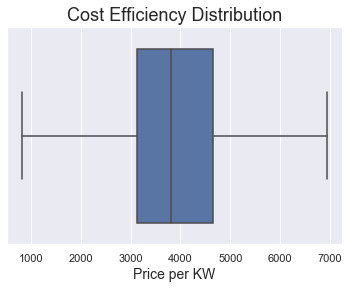

In [9]:
filepath = 'C:/Users/zbro1/Documents/GitHub/Solar-Panel-Capstone/figures/'

sns.boxplot(x = data['price_per_kw'], showfliers = False)
plt.title('Cost Efficiency Distribution', fontsize=18)
plt.xlabel('Price per KW', fontsize=14)
plt.savefig(filepath + 'cost_eff_dist', dpi=1200, box_inches='tight')
plt.show()

In [10]:
data['price_per_kw'].describe()

count    2.082570e+05
mean     3.997291e+03
std      6.011821e+03
min     -1.445439e+04
25%      3.120638e+03
50%      3.805405e+03
75%      4.645277e+03
max      2.059954e+06
Name: price_per_kw, dtype: float64

One useful tool to quickly identify a difference in distributions is the empirical cumulative distribution function (ECDF). I'd like to determine whether there are any clear differences in prices per KW in TX versus the rest of the US, so I will first create a function to quickly produce an EDCF for a given column. Then I'll create two new dataframes, one with just TX data, the other with all other states. Then I'll overlay the ECDFs of both to compare. 

In [11]:
def ecdf(column):
    n = len(column)

    # x-data for the ECDF: x
    x = np.sort(column)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [12]:
# Creating the two new dataframes
tx = data[data['state_TX'] == 1]
not_tx = data[data['state_TX'] == 0]

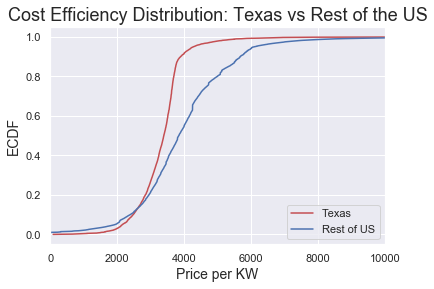

In [13]:
# Plotting the two ECDFs against one another

tx_x, tx_y = ecdf(tx['price_per_kw'])
us_x, us_y = ecdf(not_tx['price_per_kw'])

plt.plot(tx_x, tx_y, color='r')
plt.plot(us_x, us_y, color='b')
plt.xlim(0,10000)
plt.title('Cost Efficiency Distribution: Texas vs Rest of the US', fontsize=18)
plt.xlabel('Price per KW', fontsize=14)
plt.ylabel('ECDF', fontsize=14)
plt.legend(['Texas', 'Rest of US'], loc='lower right')
plt.savefig(filepath+'ecdf', dpi=1200, bbox_inches='tight')
plt.show()

Very interesting! Although the rest of the US has some installations that are more cost efficient than those in Texas, the Texas installations as a whole tend to be more cost efficient than the rest of the country. It seems likely that this will factor into the model later on. Just to confirm whether these results are significantly different, I'll run a two-tailed t-test with the null hypothesis that the mean price per KW of Texas installations and the rest of the US are the same. Before performing the t-test I need to confirm that the data are normally distributed, so I'll perform Shapiro-Wilk tests for normality first. If those results are greater than 0.05 the data is assumed to be normal and I can proceed with the t-test.

In [14]:
scipy.stats.shapiro(tx['price_per_kw'])

C:\Users\zbro1\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.4929763674736023, 0.0)

In [15]:
scipy.stats.shapiro(not_tx['price_per_kw'])

(0.07287049293518066, 0.0)

Ok, both sets of data pass the Shapiro-Wilk test, so now I'll run the t-test.

In [16]:
scipy.stats.ttest_ind(tx['price_per_kw'], not_tx['price_per_kw'])

Ttest_indResult(statistic=-8.326852184618529, pvalue=8.35145154071985e-17)

Ok, our t-test confirms that there is a real difference in average cost efficiency between Texas and the rest of the US. I'll determine the Pearson correlation coefficient to quantify how linear the relationship is.

In [17]:
scipy.stats.pearsonr(data['state_TX'], data['price_per_kw'])

(-0.01824361302718146, 8.351451543108804e-17)

So there is a -0.018 correlation coefficient between whether the installation is in Texas and the installation cost efficiency. That's good to know!  I'll keep an eye out for that to show up in the model I generate later.

It seems very possible that pricing may vary throughout the year given seasonal changes in weather. For example one might expect an increase in installations, and hence an increase in price, during the winter or spring so that the panels are ready in time for summer. I'll prepare a series of boxplots of the price per KW broken down by month to get a quick look at whether there is any month to month effect.

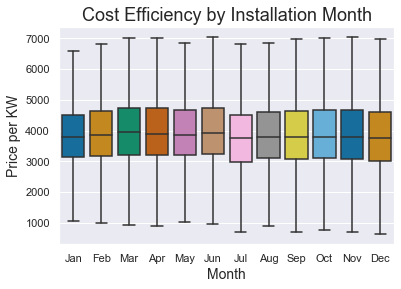

In [18]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.boxplot(x='month', y='price_per_kw', data=data, palette='colorblind', showfliers=False)
plt.title('Cost Efficiency by Installation Month', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.xticks(np.arange(12), months)
plt.ylabel('Price per KW', fontsize=14)
plt.savefig(filepath+'cost eff by month', dpi=1200, bbox_inches='tight')
plt.show()

In [19]:
chi2_month = data[['month', 'price_per_kw']].copy()
chi2_month = chi2_month[chi2_month['month'] >= 0]
chi2_month = chi2_month[chi2_month['price_per_kw'] >= 0]
scipy.stats.chi2_contingency(chi2_month)

(8730078.244294887,
 0.0,
 208250,
 array([[5.14323679e+00, 3.03701301e+03],
        [4.38285412e+00, 2.58801715e+03],
        [6.79852645e+00, 4.01443957e+03],
        ...,
        [6.23827911e+00, 3.68362096e+03],
        [7.69011285e+00, 4.54090950e+03],
        [7.24884450e+00, 4.28034639e+03]]))

Although there isn't a large obvious difference upon visual inspection of the box plots, the chi squared test suggests that there is a significant correlation between the installation month and price efficiency.

Next I want to check for quick correlations in the categorical columns such as 'expansion_system', 'multiple_phase_system', etc. To do so I'll create a loop to automatically make box plots for each.

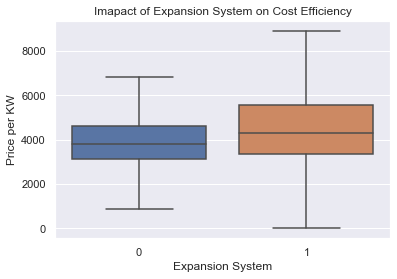

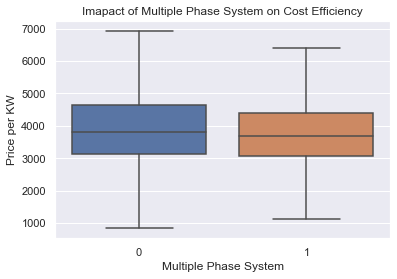

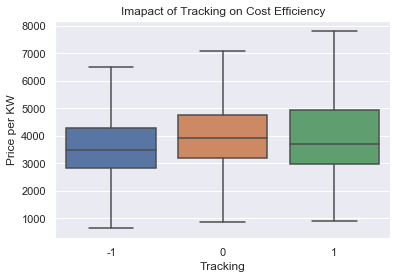

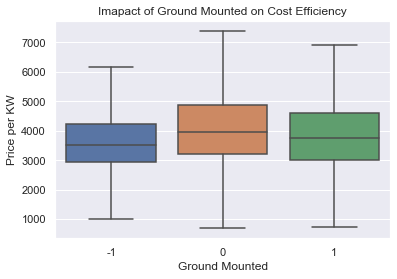

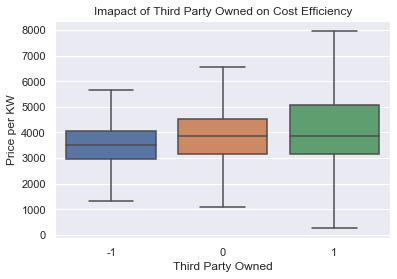

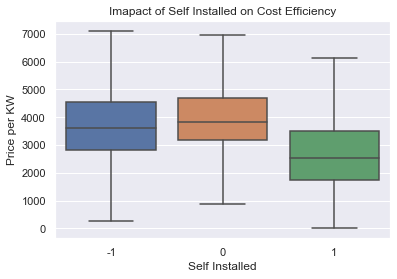

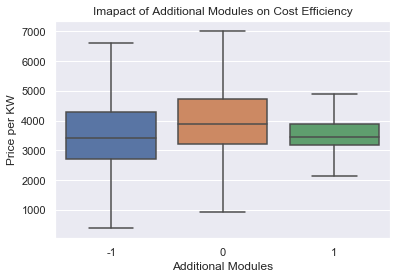

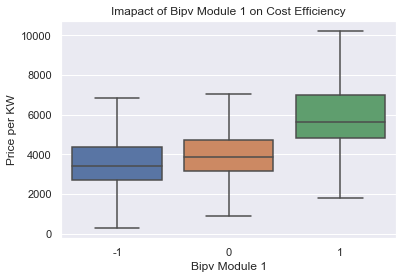

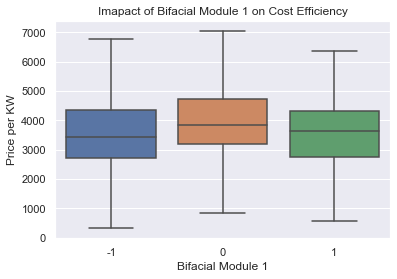

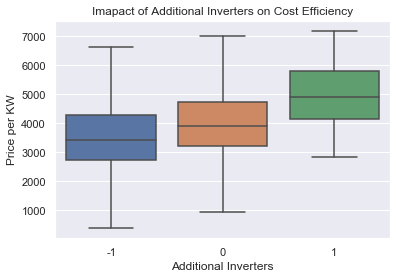

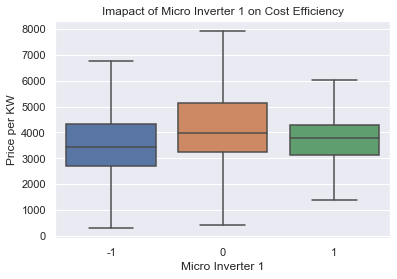

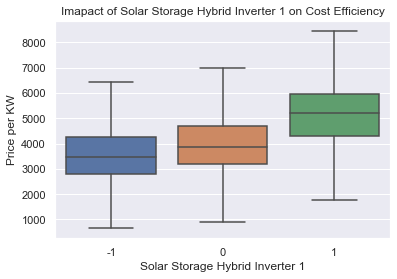

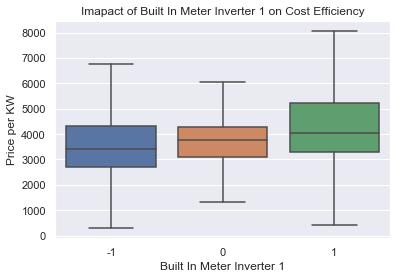

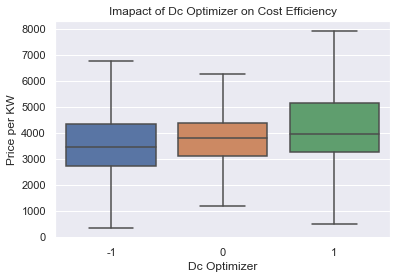

In [20]:
for col in data.columns:
    if data.dtypes[col] == 'int64' and 'state' not in col and 2 not in data[col].unique():
        sns.boxplot(x=col, y='price_per_kw', data=data, showfliers=False)
        plt.title(''.join(['Imapact of ', col.title().replace('_', " "), ' on Cost Efficiency']))
        plt.xlabel(col.title().replace('_', " "))
        plt.ylabel('Price per KW')
        plt.show()    

While there aren't any plots that show an obvious dramatic difference between their yes (1) and no (0) values, 'self_installed' and 'additional_modules' appear to improve cost efficiency, while 'bipv_module_1', 'additional_inverters', and 'solar_storage_hybrid_inverter_1' all appear to reduce cost efficiency. These may prove important to model development.

I'll go through each of those columns, remove the missing data, split the dataframes by the response to the property of interest, and then perform t-tests to identify whether the mean price per KW is different based on that property. If the t-test statistic is significant I'll then perform a Pearson correlation test to identify the correlation coefficient.

In [21]:
# self_installed
si_non_null = data[data['self_installed'] != -1]
si_yes = si_non_null[si_non_null['self_installed'] == 1]
si_no = si_non_null[si_non_null['self_installed'] == 0]
print(scipy.stats.ttest_ind(si_yes['price_per_kw'], si_no['price_per_kw']))

Ttest_indResult(statistic=-20.20552291201188, pvalue=1.0841329261436902e-90)


In [22]:
scipy.stats.pearsonr(data['self_installed'], data['price_per_kw'])

(-0.01376842989214121, 3.3101635673042163e-10)

In [23]:
# additional_modules

am_non_null = data[data['additional_modules'] != -1]
am_yes = am_non_null[am_non_null['additional_modules'] == 1]
am_no = am_non_null[am_non_null['additional_modules'] == 0]
print(scipy.stats.ttest_ind(am_yes['price_per_kw'], am_no['price_per_kw']))

Ttest_indResult(statistic=-8.461379495644366, pvalue=2.6628389496148042e-17)


In [24]:
scipy.stats.pearsonr(data['additional_modules'], data['price_per_kw'])

(0.017905754985332506, 3.034940519887365e-16)

In [25]:
# bipv_module_1 - BIPV stands for building integrated photovoltaic, where the solar panels are designed to blend in with 
# the rest of the building design.

bm1_non_null = data[data['bipv_module_1'] != -1]
bm1_yes = bm1_non_null[bm1_non_null['bipv_module_1'] == 1]
bm1_no = bm1_non_null[bm1_non_null['bipv_module_1'] == 0]
print(scipy.stats.ttest_ind(bm1_yes['price_per_kw'], bm1_no['price_per_kw']))

Ttest_indResult(statistic=12.564814058724114, pvalue=3.410581063393746e-36)


In [26]:
scipy.stats.pearsonr(data['bipv_module_1'], data['price_per_kw'])

(0.01679988950128991, 1.7585258448765175e-14)

In [27]:
# additional_inverters

ai_non_null = data[data['additional_inverters'] != -1]
ai_yes = ai_non_null[ai_non_null['additional_inverters'] == 1]
ai_no = ai_non_null[ai_non_null['additional_inverters'] == 0]
print(scipy.stats.ttest_ind(ai_yes['price_per_kw'], ai_no['price_per_kw']))

Ttest_indResult(statistic=3.499958896111896, pvalue=0.0004654487524666703)


In [28]:
scipy.stats.pearsonr(data['additional_inverters'], data['price_per_kw'])

(0.01988162398970985, 1.148758215181901e-19)

In [29]:
# solar_storage_hybrid_inverter_1

sshi1_non_null = data[data['solar_storage_hybrid_inverter_1'] != -1]
sshi1_yes = sshi1_non_null[sshi1_non_null['solar_storage_hybrid_inverter_1'] == 1]
sshi1_no = sshi1_non_null[sshi1_non_null['solar_storage_hybrid_inverter_1'] == 0]
print(scipy.stats.ttest_ind(sshi1_yes['price_per_kw'], sshi1_no['price_per_kw']))

Ttest_indResult(statistic=25.927625655684743, pvalue=6.254555956094055e-148)


In [30]:
scipy.stats.pearsonr(data['solar_storage_hybrid_inverter_1'], data['price_per_kw'])

(0.03133411787962591, 2.1015519520440926e-46)

Great, all of these properties do appear to significantly impact the cost efficiency of the installation as I predicted based on the boxplots. 

Now I want to look for any correlations between the continuous variables and price per KW to see if those play any role here. I'm going to limit the y-axis to the 99.95th percentile of the data to cut out potential outliers which may hide the shape of the bulk data.

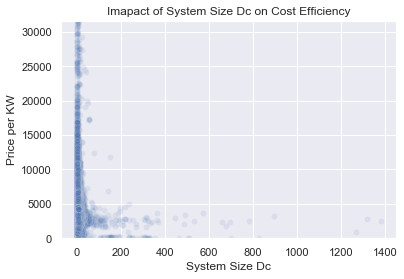

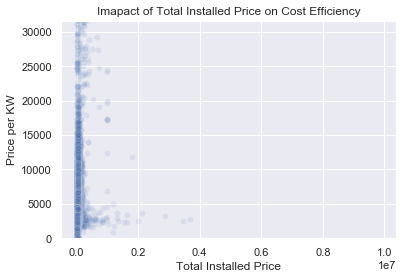

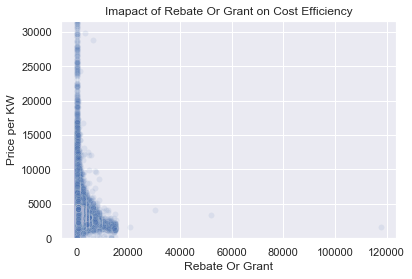

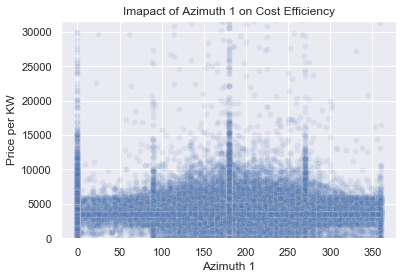

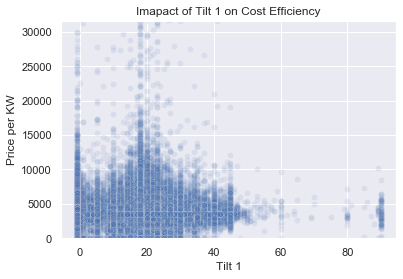

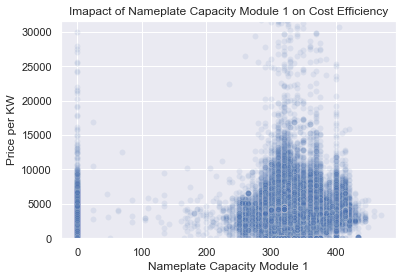

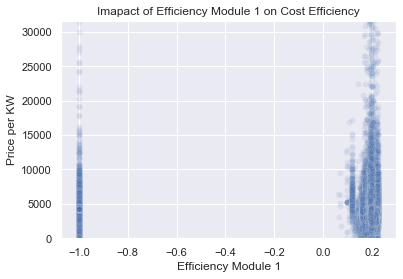

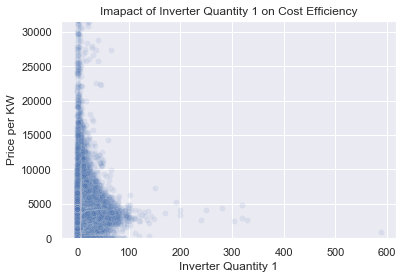

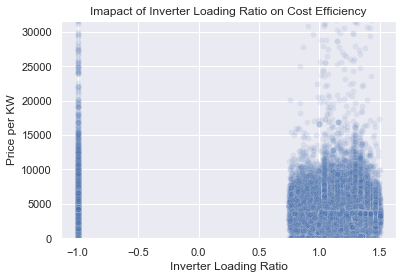

In [32]:
for col in data.select_dtypes('float64').columns:
    if col != 'price_per_kw':
        sns.scatterplot(data=data, x=col, y='price_per_kw', alpha=0.1)
        plt.title(''.join(['Imapact of ', col.title().replace('_', " "), ' on Cost Efficiency']))
        plt.xlabel(col.title().replace('_', " "))
        plt.ylabel('Price per KW')
        plt.ylim(0, np.quantile(data['price_per_kw'], 0.9995))
        plt.show()

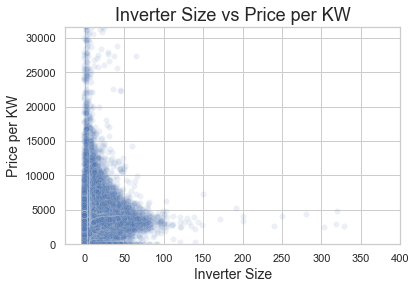

In [33]:
sns.set_style("whitegrid")
sns.scatterplot(data=data, x='inverter_quantity_1', y='price_per_kw', alpha=0.1)
plt.title('Inverter Size vs Price per KW', fontsize=18)
plt.xlabel('Inverter Size', fontsize=14)
plt.ylabel('Price per KW', fontsize=14)
plt.xlim(-25, 400)
plt.ylim(0, np.quantile(data['price_per_kw'], 0.9995))
plt.savefig(filepath+'inverter size', dpi=1200, bbox_inches='tight')
plt.show()

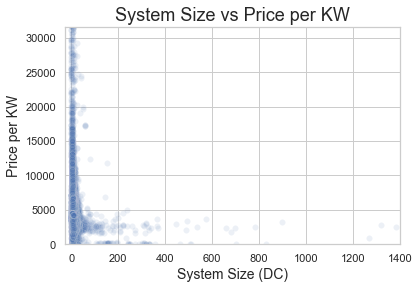

In [34]:
sns.set_style("whitegrid")
sns.scatterplot(data=data, x='system_size_dc', y='price_per_kw', alpha=0.1)
plt.title('System Size vs Price per KW', fontsize=18)
plt.xlabel('System Size (DC)', fontsize=14)
plt.ylabel('Price per KW', fontsize=14)
plt.xlim(-25, 1400)
plt.ylim(0, np.quantile(data['price_per_kw'], 0.9995))
plt.savefig(filepath+'system size', dpi=1200, bbox_inches='tight')
plt.show()

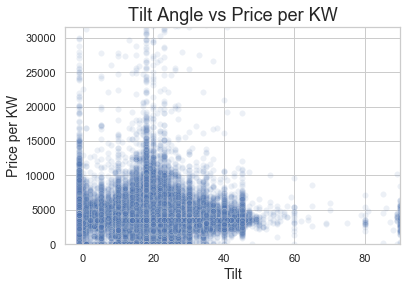

In [35]:
sns.set_style("whitegrid")
sns.scatterplot(data=data, x='tilt_1', y='price_per_kw', alpha=0.1)
plt.title('Tilt Angle vs Price per KW', fontsize=18)
plt.xlabel('Tilt', fontsize=14)
plt.ylabel('Price per KW', fontsize=14)
plt.xlim(-5, 90)
plt.ylim(0, np.quantile(data['price_per_kw'], 0.9995))
plt.savefig(filepath+'tilt', dpi=1200, bbox_inches='tight')
plt.show()

These give an interesting quick look at the data. I want to dig into a few of them a little more. I'll start with efficiency_module_1 by removing missing values, creating an OLS regression of the data, and checking the R-squared value as well as the p-values for the parameters to determine whether the model is a good representation of the data. I'll then overlay the regression line over the data to visually assess the trend.

In [36]:
# First I remove the missing data.
em1_no_null = data[data['efficiency_module_1'] != -1]

dep_em1 = em1_no_null[['price_per_kw']]
ind_em1 = sm.add_constant(em1_no_null[['efficiency_module_1']])

x_train, x_test, y_train, y_test = train_test_split(ind_em1, dep_em1, test_size=0.25)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(137404, 2) (45802, 2) (137404, 1) (45802, 1)


C:\Users\zbro1\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [37]:
# Now I'll create the model and check the R-squared.
em1_model = sm.OLS(y_train,x_train)
em1_results = em1_model.fit()
em1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_kw   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     21.06
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           4.45e-06
Time:                        09:04:09   Log-Likelihood:            -1.3334e+06
No. Observations:              137404   AIC:                         2.667e+06
Df Residuals:                  137402   BIC:                         2.667e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3229.7680    174.513     18.507      0.000    2887.726    3571.810
efficiency_module_1  4031.3027    878.381      4.589      0.000    2309.693    5752.912
==============================================================================
Omnibus:                   688551.160   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   23416966146756.410
Skew:                         217.477   Prob(JB):                         0.00
Kurtosis:                   63956.041   Cond. No.                         85.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# The R-squared is 0.000, which means the residuals are very large for this regression line. 
# Let's check the slope and intercept parameters to get an idea of their magnitudes.
b, m = em1_results.params
em1_results.params

const                  3229.767959
efficiency_module_1    4031.302687
dtype: float64

In [39]:
# Now I want to see if the parameters have significant p-values.
em1_results.pvalues

const                  2.233894e-76
efficiency_module_1    4.447629e-06
dtype: float64

In [40]:
scipy.stats.pearsonr(data['efficiency_module_1'], data['price_per_kw'])

(0.012807580920714308, 5.066665179585273e-09)

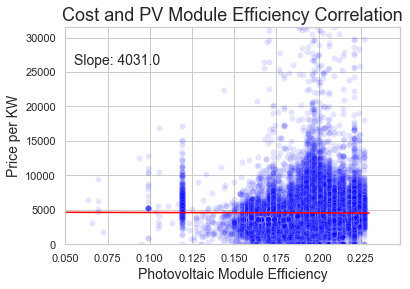

In [65]:
# I'll make the arrays for the regression line.
x=np.array([0, 0.23])
y=(m*x)+b

# And now plot the data with the regression line overlay.
sns.scatterplot(data=em1_no_null, x='efficiency_module_1', y='price_per_kw', alpha = 0.1, color='blue')
plt.plot(x, y, color='red')
plt.title('Cost and PV Module Efficiency Correlation', fontsize=18)
plt.xlim(0.05,)
plt.ylim(0, np.quantile(em1_no_null['price_per_kw'], 0.9995))
plt.xlabel('Photovoltaic Module Efficiency', fontsize=14)
plt.ylabel('Price per KW', fontsize=14)
plt.text(0.055, 26000, 'Slope: ' + str(round(em1_results.params['efficiency_module_1'])), fontsize = 14)
plt.savefig(filepath+'efficiency.png',dpi=1200, bbox_inches='tight')
plt.show()

So analysis of efficiency_module_1 shows that there is a linear correlation that is significant, however, the residuals are still very large, giving me an R-squared value of 0.000. This means that while the correlation is significant, it is not a good fit for the cost efficiency metric on its own. I'll perform the same analysis on nameplate_capacity_module_1 and inverter_loading_ratio to check those variables as well.

In [42]:
# Nameplate capacity is the maximum output the system can generate
ncm1_no_null = data[data['nameplate_capacity_module_1'] != -1]
ncm1_no_null = ncm1_no_null.dropna(axis=0, subset=['nameplate_capacity_module_1', 'price_per_kw'])

dep_ncm1 = ncm1_no_null[['price_per_kw']]
ind_ncm1 = sm.add_constant(ncm1_no_null[['nameplate_capacity_module_1']])

X_train, X_test, y_train, y_test = train_test_split(ind_ncm1, dep_ncm1, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(139324, 2) (46442, 2) (139324, 1) (46442, 1)


C:\Users\zbro1\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
ncm1_model = sm.OLS(y_train,X_train)
ncm1_results = ncm1_model.fit()
ncm1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_kw   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6350
Date:                Sun, 15 Jan 2023   Prob (F-statistic):              0.426
Time:                        09:05:07   Log-Likelihood:            -1.3514e+06
No. Observations:              139324   AIC:                         2.703e+06
Df Residuals:                  139322   BIC:                         2.703e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        3917.4184    137.926     28.402      0.000    3647.085    4187.751
nameplate_capacity_module_1     0.3324      0.417      0.797      0.426      -0.485       1.150
==============================================================================
Omnibus:                   698303.159   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   23998338140089.875
Skew:                         217.616   Prob(JB):                         0.00
Kurtosis:                   64297.421   Cond. No.                     4.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Once again the R-squared is 0.000, which means the residuals are very large for this regression line. 
# Let's assign the slope and intercept parameters to variables so we can plot them later.
b, m = ncm1_results.params
ncm1_results.params

const                          3917.418363
nameplate_capacity_module_1       0.332411
dtype: float64

In [45]:
# Now I want to see if the parameters have significant p-values.
ncm1_results.pvalues

const                          6.085971e-177
nameplate_capacity_module_1     4.255157e-01
dtype: float64

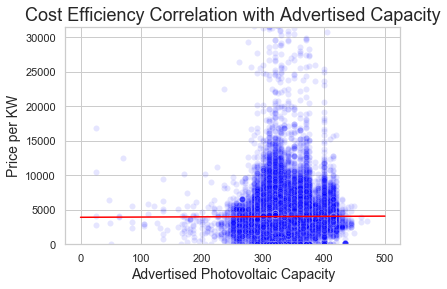

In [46]:
# I'll make the arrays for the regression line.
x=np.array([0, 500])
y=(m*x)+b

# And now plot the data with the regression line overlay.
sns.scatterplot(data=ncm1_no_null, x='nameplate_capacity_module_1', y='price_per_kw', alpha = 0.1, color='blue')
plt.plot(x, y, color='red')
plt.title('Cost Efficiency Correlation with Advertised Capacity', fontsize=18)
plt.ylim(0, np.quantile(ncm1_no_null['price_per_kw'], 0.9995))
plt.xlabel('Advertised Photovoltaic Capacity', fontsize=14)
plt.ylabel('Price per KW', fontsize=14)
plt.show()

This regression line not only appears flat and has an R-squared of 0.000, but also has a p-value for the slope of 0.86, suggesting that nameplate_capacity_module_1 is not significantly correlated to the price_per_kw. The last continuous feature that looks worth checking is inverter_loading_ratio.

In [47]:
ilr_no_null = data[data['inverter_loading_ratio'] != -1]
ilr_no_null = ilr_no_null.dropna(axis=0, subset=['inverter_loading_ratio', 'price_per_kw'])

dep_ilr = ilr_no_null[['price_per_kw']]
ind_ilr = sm.add_constant(ilr_no_null[['inverter_loading_ratio']])

X_train, X_test, y_train, y_test = train_test_split(ind_ilr, dep_ilr, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(122970, 2) (40990, 2) (122970, 1) (40990, 1)


C:\Users\zbro1\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
ilr_model = sm.OLS(y_train,X_train)
ilr_results = ilr_model.fit()
ilr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_kw   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     52.88
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           3.57e-13
Time:                        09:05:09   Log-Likelihood:            -1.1963e+06
No. Observations:              122970   AIC:                         2.393e+06
Df Residuals:                  122968   BIC:                         2.393e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4669.1054     89.219     52.333      0.000    4494.237    4843.974
inverter_loading_ratio  -556.7623     76.566     -7.272      0.000    -706.830    -406.695
==============================================================================
Omnibus:                   622356.631   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21532656425045.863
Skew:                         225.319   Prob(JB):                         0.00
Kurtosis:                   64828.272   Cond. No.                         15.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Once again the R-squared is 0.000, which means the residuals are very large for this regression line. 
# Let's assign the slope and intercept parameters to variables so we can plot them later.
b, m = ilr_results.params
ilr_results.params

const                     4669.105416
inverter_loading_ratio    -556.762270
dtype: float64

In [50]:
# Now I want to see if the parameters have significant p-values.
ilr_results.pvalues

const                     0.000000e+00
inverter_loading_ratio    3.570881e-13
dtype: float64

In [51]:
scipy.stats.pearsonr(data['inverter_loading_ratio'], data['price_per_kw'])

(0.004785559875399484, 0.02896971167271711)

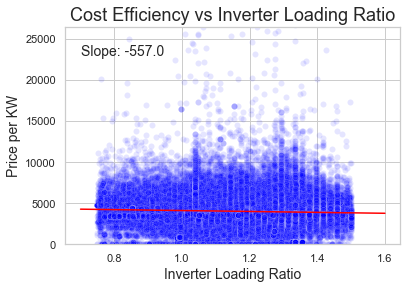

In [63]:
# I'll make the arrays for the regression line.
x=np.array([0.7, 1.6])
y=(m*x)+b

# And now plot the data with the regression line overlay.
sns.scatterplot(data=ilr_no_null, x='inverter_loading_ratio', y='price_per_kw', alpha = 0.1, color='blue')
plt.plot(x, y, color='red')
plt.title('Cost Efficiency vs Inverter Loading Ratio', fontsize=18)
plt.ylim(0, np.quantile(ilr_no_null['price_per_kw'], 0.9995))
plt.xlabel('Inverter Loading Ratio', fontsize=14)
plt.ylabel('Price per KW', fontsize=14)
plt.text(0.7, 23000, 'Slope: ' + str(round(ilr_results.params['inverter_loading_ratio'])), fontsize = 14)
plt.savefig('inverter loading ratio', dpi=1200, bbox_inches='tight')
plt.show()

Once again we have an R-squared of 0, so the inverter_loading_ratio doesn't predict the cost efficiency well on its own, however, the p-value for the slope of the regression line suggests that there is a significant correlation here that I may need to consider when building a model.

One of the last columns I haven't dealt with yet is the date of battery install variable. It's listed as an object type right now, so I'm going to have to check how it's formatted, change it to datetime, break it out to month and year, then check each for any meaningful correlations to cost efficiency.

In [53]:
dobi = data[~data['date_of_battery_install'].isnull()]
print(dobi['date_of_battery_install'].head())

108831    2020-07-10
109237    2020-07-23
109521    2020-07-30
109677    2020-08-04
109819    2020-08-07
Name: date_of_battery_install, dtype: object


In [54]:
dobi_c = dobi.copy()
dobi_c['date_of_battery_install'] = pd.to_datetime(dobi_c['date_of_battery_install'])
dobi_c['month_of_battery_install'] = dobi_c['date_of_battery_install'].dt.month
dobi_c['year_of_battery_install'] = dobi_c['date_of_battery_install'].dt.year

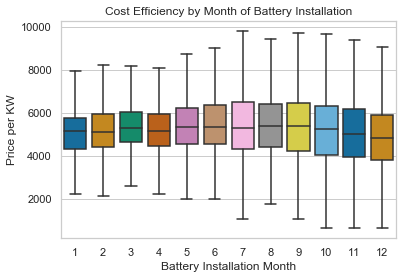

In [55]:
sns.boxplot(x='month_of_battery_install', y='price_per_kw', data=dobi_c, palette='colorblind', showfliers=False)
plt.title('Cost Efficiency by Month of Battery Installation')
plt.xlabel('Battery Installation Month')
plt.ylabel('Price per KW')
plt.show()

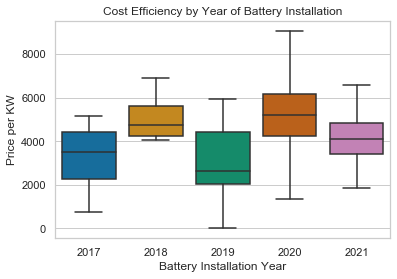

In [56]:
sns.boxplot(x='year_of_battery_install', y='price_per_kw', data=dobi_c, palette='colorblind', showfliers = False)
plt.title('Cost Efficiency by Year of Battery Installation')
plt.xlabel('Battery Installation Year')
plt.ylabel('Price per KW')
plt.show()

Now these are really interesting. It looks like we have more cost efficiency variation when looking at battery installation month than solar panel installation month, and even more interestingly, there are large differences in cost efficiency when split by the year of a battery installation. 

I'll perform chi-squared contingency tests on both to confirm whether the categories of each variable (month and year of battery install) are independent or not.

In [57]:
chi_month = dobi_c[['month_of_battery_install', 'price_per_kw']].copy()
scipy.stats.chi2_contingency(chi_month)

(418970.3381867314,
 0.0,
 13222,
 array([[3.91751659e+00, 2.94425895e+03],
        [4.30907784e+00, 3.23854174e+03],
        [3.68788136e+00, 2.77167370e+03],
        ...,
        [8.87818245e+00, 6.67250988e+03],
        [4.15405642e+00, 3.12203344e+03],
        [5.97839922e+00, 4.49314126e+03]]))

In [58]:
chi_year = dobi_c[['year_of_battery_install', 'price_per_kw']].copy()
scipy.stats.chi2_contingency(chi_year)

(2950511.54237134,
 0.0,
 13222,
 array([[1357.12205361, 3604.05441698],
        [1437.72975926, 3818.12105659],
        [1309.84881147, 3478.51277045],
        ...,
        [2377.7891402 , 6314.5989195 ],
        [1405.26959505, 3731.91790495],
        [1783.02142417, 4735.09823395]]))

In both cases we get very large chi-squared values and p-values of 0.0, meaning that the month and year of battery installation do have an impact on cost efficiency of the solar panel installation.

I'll need to export the updated dataframe for modeling to make sure I capture those broken out date features in the model.

In [59]:
print(os.getcwd())
os.chdir(r"..\processed")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\interim
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed


### Conclusions
As a final wrap-up of this analysis I'll summarize the findings below.

The Pearson correlation coefficients for categorical features with statistically significant impact on cost efficiency are listed below:

* state_TX - -0.018 
* self_installed: -0.014 
* additional_modules: 0.018 
* bipv_module_1: 0.017 
* additional_inverters: 0.020 
* solar_storage_hybrid_inverter_1: 0.031 

Although none of the continuous features had an R-squared above 0.000, two features both had significant p-values for their regression line slopes, suggesting that they do have some correlation with price_per_kw. They're listed below with their Pearson correlation coefficients:

* efficiency_module_1: 0.013
* inverter_loading_ratio: 0.005

All of these correlation coefficients suggest that there are very slightly linear correlations between the listed features and the overall installation cost efficiency. In the case of state_TX and self_installed, being self installed or installed in Texas both reduce the cost per KW, whereas the other factors all increase the cost per KW.

One final interesting finding was that the month of both battery and solar panel installation, as well as the year of battery installation, all have significant impact on the overall cost efficiency of the solar panel installation.

These should help me know what to watch for as I develop a model to predict how to optimize cost efficiency in the next step of this capstone.

In [60]:
data.to_csv('processed_data.csv')